In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
import pandas as pd
import copy
import sys
from glob import glob
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm
%run ./plot_functions.ipynb
sys.path.insert(0, '../src/')


output_path =  ../output/figures
plt = single_column_plt_params(plt)
plt = double_column_plt_params(plt)


In [2]:
from analyze_utilities import *
# from dataset_utilities import create_cifar10_dataloaders
from distributions_metrics import *
plt = single_column_plt_params(plt)


# ODIN Baseline


ODIN:
    AUROC   AP-In  AP-Out  KL Divergence  KL in P_lamb
0  98.862  98.914  98.868          0.542         0.139


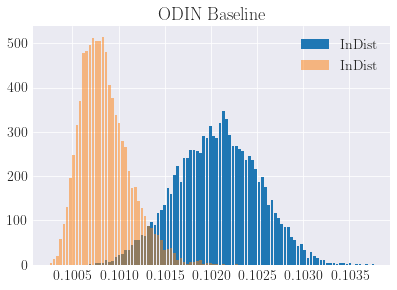

In [3]:
# ODIN baseline: with pNML fraemwork
file_baseline_cifar10 = '../output/baseline_odin_densenet_cifar10_cifar10_20190926_184650/results_baseline_odin_densenet_cifar10_cifar10_20190926_184650.json'
file_baseline_isun = '../output/baseline_odin_densenet_cifar10_isun_20190926_184648/results_baseline_odin_densenet_cifar10_isun_20190926_184648.json'

with open(file_baseline_cifar10) as data_file:
    ind_df = result_dict_to_erm_df(json.load(data_file), is_out_of_dist=True)
ind_df = ind_df.add_prefix('erm_')
ind_df.index = ind_df.index.astype(int)
ind_df_odin = ind_df.sort_index()
print()
with open(file_baseline_isun) as data_file:
    ood_df = result_dict_to_erm_df(json.load(data_file), is_out_of_dist=True)
ood_df = ood_df.add_prefix('erm_')
ood_df.index = ood_df.index.astype(int)
ood_df_odin = ood_df.sort_index()

# Baseline Max prob of ERM
y_score_ind = ind_df_odin[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist() + \
    ood_df_odin[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist()
y_true_ind = [True] * ind_df_odin.shape[0] + [False] * ood_df_odin.shape[0]
baseline_performance = calc_performance_in_out_dist(y_true_ind, y_score_ind)

y_score_ind = np.array(y_score_ind)
y_true_ind = np.array(y_true_ind)

print('ODIN:')
print(baseline_performance.round(3))

bins = 100
min_r = np.min(y_score_ind)
max_r = np.max(y_score_ind)
_, bins, _ = plt.hist(y_score_ind[y_true_ind], range=[
                      min_r, max_r], rwidth=0.8, bins=bins, label='InDist')
plt.hist(y_score_ind[np.logical_not(y_true_ind)], rwidth=0.9,
         alpha=0.5, bins=bins,  label='InDist')
plt.title('ODIN Baseline')
plt.legend()
plt.show()


# Linear regression

In [10]:
def compute_regret(x_m_train: np.ndarray, x_m_test: np.ndarray, lamb: float):
    n = x_m_train.shape[1]

    # SVD decomposition
    u, s, vh = np.linalg.svd(x_m_train)
    eta = s ** 2
    eta = eta[:, np.newaxis]

    # Calc mean regret
    x_t_u_2 = (x_m_test.T.dot(u)) ** 2
    div = x_t_u_2 / \
        (eta +
         lamb) if eta.shape[0] == x_t_u_2.shape[0] else x_t_u_2 / (eta.T + lamb)
    regret_all = np.log(1 + (1 / n) * div.sum(axis=1))
    return regret_all.tolist()
#     return div.sum(axis=1).tolist()


def plot_ood(regret_ind_list: list, regret_ood_list: list, dataset_name: str):
    min_r = np.min(regret_ind_list+regret_ood_list)
    max_r = np.max(regret_ind_list+regret_ood_list)
    _, bins, _ = plt.hist(regret_ind_list, bins=100,  range=[min_r, max_r],
                          label='InDist', rwidth=0.8)
    plt.hist(regret_ood_list, bins=bins, alpha=0.5,
             label='OutOfDist', rwidth=0.8)
    plt.title(dataset_name)
    plt.legend()
    plt.yscale('symlog')
    plt.show()


def analyze_ind_ood(trainset_all: np.ndarray, train_labels: np.ndarray, testset_ind: np.ndarray, testset_ood: np.ndarray):
    regret_ind_list_all = []
    regret_ood_list_all = []

    for class_num in tqdm(np.unique(train_labels)):
        trainset = trainset_all[:, train_labels == class_num]
        trainset_mean = np.mean(trainset.mean(axis=1))

#         # Normalize?
#         trainset = trainset - trainset_mean
#         testset_ind_calc = testset_ind - trainset_mean
#         testset_ood_calc = testset_ood - trainset_mean

        #
        testset_ind_calc = testset_ind
        testset_ood_calc = testset_ood

        regret_ind_list_all.append(compute_regret(
            trainset, testset_ind_calc, lamb=0))
        regret_ood_list_all.append(compute_regret(
            trainset, testset_ood_calc, lamb=0))

    regret_ind_np = np.asarray(regret_ind_list_all)
    regret_ood_np = np.asarray(regret_ood_list_all)

    regret_ind_list = regret_ind_np.min(axis=0).tolist()
    regret_ood_list = regret_ood_np.min(axis=0).tolist()

    y_score_ind = regret_ind_list + regret_ood_list
    y_score_ind = 1 - np.array(y_score_ind)
    y_true_ind = [True] * len(regret_ind_list) + [False] * len(regret_ood_list)
    performance = calc_performance_in_out_dist(y_true_ind, y_score_ind)

    return performance, regret_ind_list, regret_ood_list


## Densnet CIFAR100

Labels 100



                     AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)  87.904516  87.048085  88.759393       1.771857      0.486434


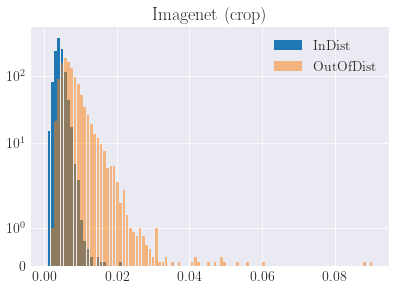


                       AUROC      AP-In     AP-Out  KL Divergence  \
Imagenet (resize)  96.179621  96.041663  96.355093       0.660134   

                   KL in P_lamb  
Imagenet (resize)      0.167734  


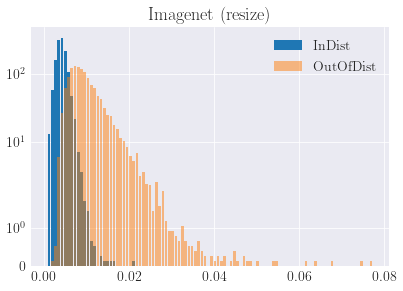


                 AUROC      AP-In    AP-Out  KL Divergence  KL in P_lamb
LSUN (crop)  60.058649  62.159629  61.06394       3.434348      0.956307


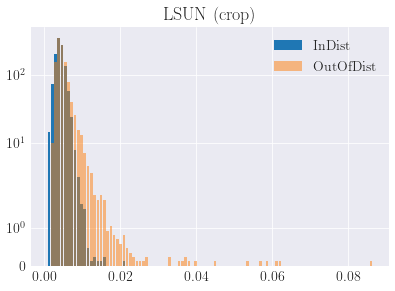


                   AUROC      AP-In    AP-Out  KL Divergence  KL in P_lamb
LSUN (resize)  97.210145  97.332858  96.99145        1.31802      0.350047


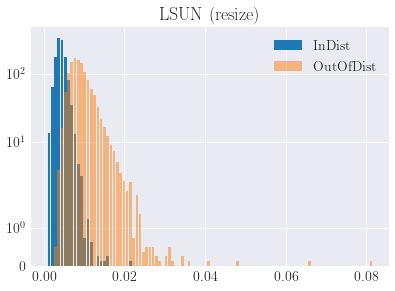


          AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
iSUN  97.219388  97.275662  97.137635       0.708075      0.184034


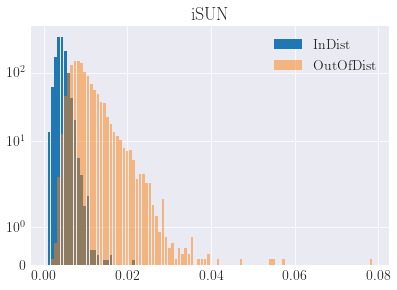

Densnet CIFAR100:
                   AUROC  AP-In  AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)    87.90  87.05   88.76           1.77          0.49
Imagenet (resize)  96.18  96.04   96.36           0.66          0.17
LSUN (crop)        60.06  62.16   61.06           3.43          0.96
LSUN (resize)      97.21  97.33   96.99           1.32          0.35
iSUN               97.22  97.28   97.14           0.71          0.18


In [8]:
trainset_all = np.load(
    '../output/embeddings/densenet_cifar100_cifar100_train.npy').T
testset_ind = np.load(
    '../output/embeddings/densenet_cifar100_cifar100_test.npy').T
train_labels = np.load('../output/embeddings/cifar100_train_labels.npy')


datasets = [('Imagenet (crop)', '../output/embeddings/densenet_cifar100_Imagenet_test.npy'),
            ('Imagenet (resize)',
             '../output/embeddings/densenet_cifar100_Imagenet_resize_test.npy'),
            ('LSUN (crop)', '../output/embeddings/densenet_cifar100_LSUN_test.npy'),
            ('LSUN (resize)', '../output/embeddings/densenet_cifar100_LSUN_resize_test.npy'),
            ('iSUN', '../output/embeddings/densenet_cifar100_iSUN_test.npy')
            ]
print('Labels {}'.format(len(np.unique(train_labels))))
performance_list = []
for (name, npy_path) in datasets:
    performance, regret_ind_list, regret_ood_list = analyze_ind_ood(trainset_all, train_labels, testset_ind,
                                                                    np.load(npy_path).T)
    performance = performance.rename(index={0: name})
    print(performance)
    plot_ood(regret_ind_list, regret_ood_list, name)
    performance_list.append(performance)
result_cifar100 = pd.concat(performance_list)
print('Densnet CIFAR100:')
print(result_cifar100.round(2))


## Densnet CIFAR10

Labels 10



                     AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)  97.440749  97.405059  97.593876      11.736068      2.240547


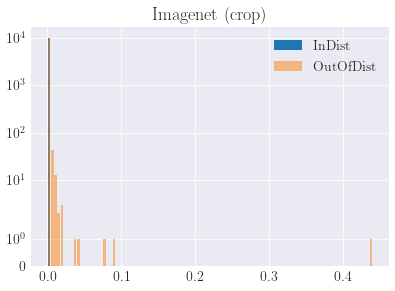


                       AUROC      AP-In     AP-Out  KL Divergence  \
Imagenet (resize)  96.688285  96.557273  96.818988      10.981363   

                   KL in P_lamb  
Imagenet (resize)       2.22725  


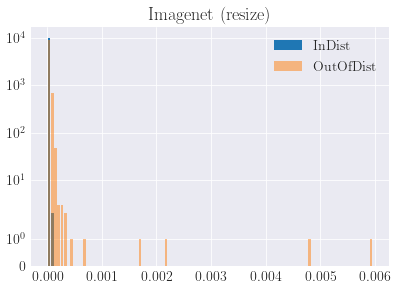


                 AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
LSUN (crop)  94.315965  94.442337  94.475825       5.246784      1.715768


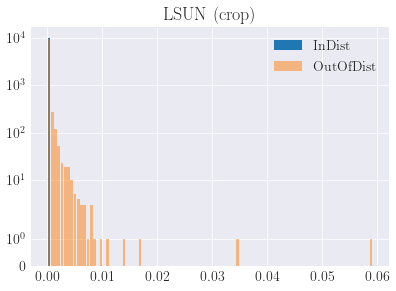


                   AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
LSUN (resize)  97.956123  98.073359  97.790891      13.260812      2.342996


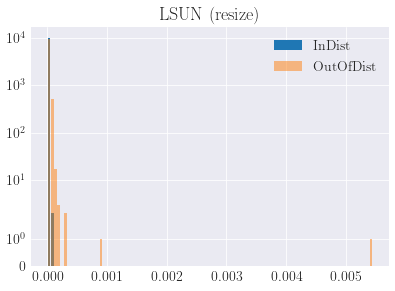


          AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
iSUN  97.571352  97.552784  97.533161       7.586345      1.828769


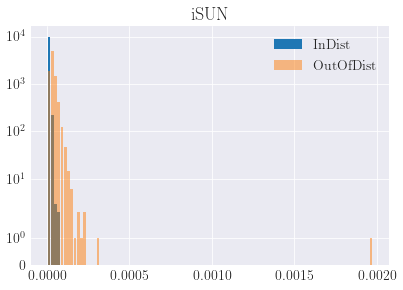

Densnet CIFAR10:
                   AUROC  AP-In  AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)    97.44  97.41   97.59          11.74          2.24
Imagenet (resize)  96.69  96.56   96.82          10.98          2.23
LSUN (crop)        94.32  94.44   94.48           5.25          1.72
LSUN (resize)      97.96  98.07   97.79          13.26          2.34
iSUN               97.57  97.55   97.53           7.59          1.83


In [11]:
trainset_all = np.load(
    '../output/embeddings/densenet_cifar10_cifar10_train.npy').T
testset_ind = np.load(
    '../output/embeddings/densenet_cifar10_cifar10_test.npy').T
train_labels = np.load('../output/embeddings/cifar10_train_labels.npy')


datasets = [('Imagenet (crop)', '../output/embeddings/densenet_cifar10_Imagenet_test.npy'),
            ('Imagenet (resize)',
             '../output/embeddings/densenet_cifar10_Imagenet_resize_test.npy'),
            ('LSUN (crop)', '../output/embeddings/densenet_cifar10_LSUN_test.npy'),
            ('LSUN (resize)', '../output/embeddings/densenet_cifar10_LSUN_resize_test.npy'),
            ('iSUN', '../output/embeddings/densenet_cifar10_iSUN_test.npy')
            ]
performance_list = []
print('Labels {}'.format(len(np.unique(train_labels))))
for (name, npy_path) in datasets:
    performance, regret_ind_list, regret_ood_list = analyze_ind_ood(trainset_all, train_labels, testset_ind,
                                                                    np.load(npy_path).T)
    performance = performance.rename(index={0: name})
    print(performance)
    plot_ood(regret_ind_list, regret_ood_list, name)
    performance_list.append(performance)
result_cifar10 = pd.concat(performance_list)
print('Densnet CIFAR10:')
print(result_cifar10.round(2))


## ODIN CIFAR100

In [ ]:
trainset_all = np.load(
    '../output/embeddings/densenet_cifar100_cifar100_train.npy').T
testset_ind = np.load(
    '../output/embeddings/densenet_cifar100_cifar100_test_odin.npy').T
train_labels = np.load('../output/embeddings/cifar100_train_labels.npy')


datasets = [('Imagenet (crop)', '../output/embeddings/densenet_cifar100_Imagenet_test_odin.npy'),
            ('Imagenet (resize)',
             '../output/embeddings/densenet_cifar100_Imagenet_resize_test_odin.npy'),
            ('LSUN (crop)', '../output/embeddings/densenet_cifar100_LSUN_test_odin.npy'),
            ('LSUN (resize)',
             '../output/embeddings/densenet_cifar100_LSUN_resize_test_odin.npy'),
            ('iSUN', '../output/embeddings/densenet_cifar100_iSUN_test_odin.npy')
            ]
performance_list = []
print('Labels {}'.format(len(np.unique(train_labels))))
for (name, npy_path) in datasets:
    performance, regret_ind_list, regret_ood_list = analyze_ind_ood(trainset_all, train_labels, testset_ind,
                                                                    np.load(npy_path).T)
    performance = performance.rename(index={0: name})
    print(performance)
    plot_ood(regret_ind_list, regret_ood_list, name)
    performance_list.append(performance)
result_cifar100 = pd.concat(performance_list)
print('Densnet CIFAR100 with ODIN preprocess:')
print(result_cifar100.round(2))


## ODIN CIFAR10

In [ ]:
trainset_all = np.load(
    '../output/embeddings/densenet_cifar10_cifar10_train.npy').T
testset_ind = np.load(
    '../output/embeddings/densenet_cifar10_cifar10_test_odin.npy').T
train_labels = np.load('../output/embeddings/cifar10_train_labels.npy')


datasets = [('Imagenet (crop)', '../output/embeddings/densenet_cifar10_Imagenet_test_odin.npy'),
            ('Imagenet (resize)',
             '../output/embeddings/densenet_cifar10_Imagenet_resize_test_odin.npy'),
            ('LSUN (crop)', '../output/embeddings/densenet_cifar10_LSUN_test_odin.npy'),
            ('LSUN (resize)',
             '../output/embeddings/densenet_cifar10_LSUN_resize_test_odin.npy'),
            ('iSUN', '../output/embeddings/densenet_cifar10_iSUN_test_odin.npy')
            ]
performance_list = []
print('Labels {}'.format(len(np.unique(train_labels))))
for (name, npy_path) in datasets:
    performance, regret_ind_list, regret_ood_list = analyze_ind_ood(trainset_all, train_labels, testset_ind,
                                                                    np.load(npy_path).T)
    performance = performance.rename(index={0: name})
    print(performance)
    plot_ood(regret_ind_list, regret_ood_list, name)
    performance_list.append(performance)
result_cifar10 = pd.concat(performance_list)
print('Densnet CIFAR10 with ODIN preprocess:')
print(result_cifar10.round(2))
